# Product Categorization

## Part 3: Multi-Class Text Classification of products based on their description

The aim of the project was multi-class text classification of make-up products based on their description and categories. Based on given text as an input I have predicted what would be the category. There are five types of categories corresponding to different makeup products. In this case I have used different machine learning algorithms to get more accurate predictions and choose the most accurate one for the issue. The following classification algorithms have been used: Logistic Regression, Multinomial Naive Bayes, Linear Support Vector Machine (LinearSVM), Random Forest and Gradient Boosting as well. To calculated I have used python and their libraries: pandas, matplotlib, NLTK and scikit-learn.

### Dataset

The dataset comes from http://makeup-api.herokuapp.com/ and has been obtained by an API.

The dataset contains the real descriptions about makeup products. Each description has been labeled with a specific product, therefore, this is a supervised text classification problem. 

Attributes:

- product_type - category of makeup product.
- description - description of makeup product.

## Import libriaries and data

In [55]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.tokenize import sent_tokenize, word_tokenize

from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline

from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import LinearSVC

from sklearn.metrics import accuracy_score, classification_report

import pickle
from joblib import dump, load

For the analysis I have used data with only two variables: product_type and description.

In [5]:
df = pd.read_csv('data\products_description.csv', header=0,index_col=0)
df.head()

,product_type,description
0,lip_liner,Lippie Pencil A long-wearing and high-intensit...
1,lipstick,Blotted Lip Sheer matte lipstick that creates ...
2,lipstick,"Lippie Stix Formula contains Vitamin E, Mango,..."
3,foundation,"Developed for the Selfie Age, our buildable fu..."
4,lipstick,All of our products are free from lead and hea...


Firts observations:

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 906 entries, 0 to 930
Data columns (total 2 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   product_type  906 non-null    object
 1   description   906 non-null    object
dtypes: object(2)
memory usage: 21.2+ KB


Shape of data:

In [7]:
df.shape

(906, 2)

Checking the missing values in data:

In [8]:
df.isnull().sum()

product_type    0
description     0
dtype: int64

Example description:

In [9]:
df['description'][3]

'Developed for the Selfie Age, our buildable full coverage, natural matte foundation delivers flawless looking skin from day-to-night. The oil-free, lightweight formula blends smoothly and is easily customizable to create the coverage you want. Build it up or sheer it out, it was developed with innovative soft-blurring pigments to deliver true color while looking and feeling natural. The lockable pump is easy to use and keeps your routine mess-free! As always, 100% cruelty-free and vegan.'

## Data Cleaning

Change data type:

In [22]:
df['description'] = df['description'].astype(str)

In [11]:
print(df['description'].apply(lambda x: len(x.split(' '))).sum())

94257


There are 94 282 words in the data.

In [33]:
text_df.product_type.unique()

array(['lip_liner', 'lipstick', 'foundation', 'eyeliner', 'eyeshadow',
       'blush', 'bronzer', 'mascara', 'eyebrow', 'nail_polish'],
      dtype=object)

#### Grouping data to a smaller number of categories:

There are 10 unique products and some of them can group to one category. One can link 'eyeliner', 'eyeshadow', 'mascara', 'eyebrow' to one group called as 'eye_makeup'. The same apply to 'blush' and 'bronzer' as 'contour' and 'lipstick' with 'lip_liner' to 'lipstick'. 

In [12]:
df.product_type.value_counts()

foundation     159
lipstick       148
eyeliner       145
mascara         91
eyeshadow       86
blush           75
bronzer         69
nail_polish     60
eyebrow         45
lip_liner       28
Name: product_type, dtype: int64

In [13]:
def grouping_data(df):
    '''Function to grouping data to a smaller number of categories'''
    df.loc[df['product_type'].isin(['lipstick','lip_liner']),'product_type'] = 'lipstick'
    df.loc[df['product_type'].isin(['blush','bronzer']),'product_type'] = 'contour'
    df.loc[df['product_type'].isin(['eyeliner','eyeshadow','mascara','eyebrow']),'product_type'] = 'eye_makeup'
    return df

In [15]:
df = grouping_data(df)

From above calculation received a five group of categories: Eye makeup, Lipstick, Foundation, Contour and Nail polish.

I also determined length of characters in each description:

In [17]:
df['length'] = df['description'].apply(len)
df.head()

,product_type,description,length
0,lipstick,Lippie Pencil A long-wearing and high-intensit...,232
1,lipstick,Blotted Lip Sheer matte lipstick that creates ...,146
2,lipstick,"Lippie Stix Formula contains Vitamin E, Mango,...",188
3,foundation,"Developed for the Selfie Age, our buildable fu...",492
4,lipstick,All of our products are free from lead and hea...,357


## Basic data analysis

Checking proportion product_type variable:

In [18]:
df.product_type.value_counts()

eye_makeup     367
lipstick       176
foundation     159
contour        144
nail_polish     60
Name: product_type, dtype: int64

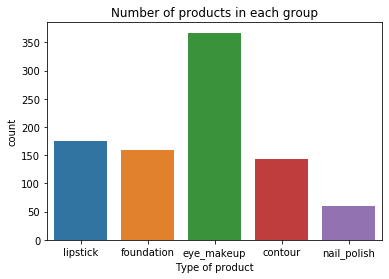

In [19]:
sns.countplot(x='product_type',data=df)
plt.xlabel('Type of product')
plt.title('Number of products in each group');

One can see that products from the eye makeup group is the largest one. It is over two times larger than in the lipstick group.

#### The length of characters in all categories:

Histogram of description length:

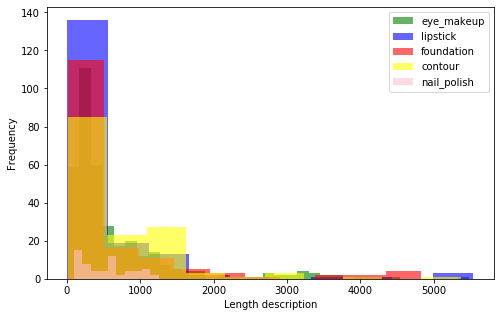

In [20]:
plt.figure(figsize=(8, 5))
df[df.product_type == 'eye_makeup'].length.plot(bins=35, kind='hist', color='green', label='eye_makeup', alpha=0.6)
df[df.product_type == 'lipstick'].length.plot(kind='hist', color='blue', label='lipstick', alpha=0.6)
df[df.product_type == 'foundation'].length.plot(kind='hist', color='red', label='foundation', alpha=0.6)
df[df.product_type == 'contour'].length.plot(kind='hist', color='yellow', label='contour', alpha=0.6)
df[df.product_type == 'nail_polish'].length.plot(kind='hist', color='pink', label='nail_polish', alpha=0.6)
plt.legend()
plt.xlabel("Length description");

#### The length of characters divided into categories:

Histogram of description length of each categories:

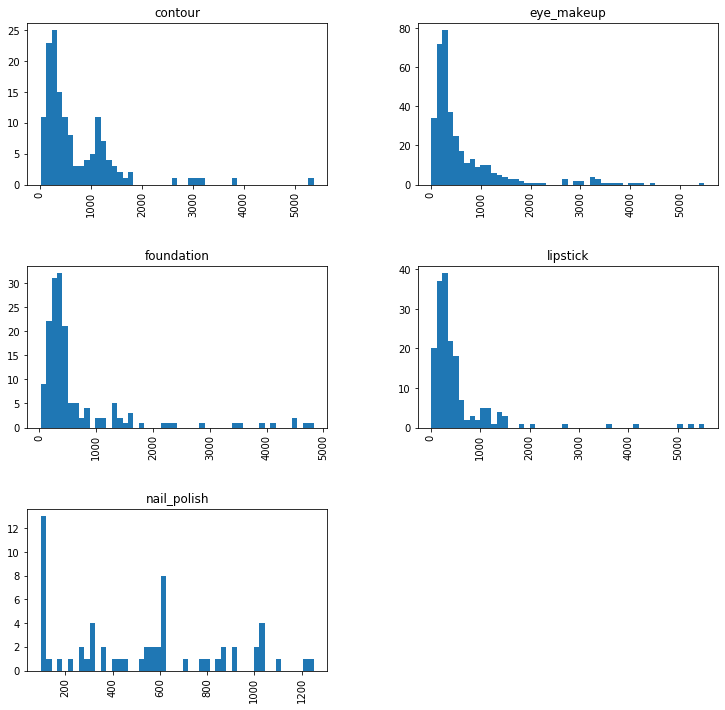

In [21]:
df.hist(column='length', by='product_type', bins=50,figsize=(12,12));

The largest description has almost 200 characters and some of them are very short.

## Text Pre-processing

In this step I have to remove punctuation, stop words, bad characters and so on. The second step is aimed to convertion all of the words to lower case and then stemmed them using the Porter Stemmer in the NLTK package.

**Stemming** operation bundles together words of same root. E.g. stem operation bundles “fishing”,  and “fished” into a common "fish".

The function to clean text, remove stop words and apply stemming operation for each line of text:

In [23]:
stop = stopwords.words('english')
print(stop[::10])

porter = PorterStemmer()

['i', "you've", 'himself', 'they', 'that', 'been', 'a', 'while', 'through', 'in', 'here', 'few', 'own', 'just', 're', 'doesn', 'ma', "shouldn't"]


In [24]:
def preprocess_data(text):
    ''' The function to remove punctuation,
    stopwords and apply stemming'''
    words = re.sub("[^a-zA-Z]", " ", text)
    words = [word.lower() for word in text.split() if word.lower() not in stop]
    words = [porter.stem(word) for word in words]
    return " ".join(words)

Apply the function to each examples:

In [26]:
df['description'] = df['description'].apply(preprocess_data)

In [28]:
df['description'][2]

'lippi stix formula contain vitamin e, mango, avocado, shea butter ad comfort moisture. none lippi formula contain nasti ingredi like paraben sulfates.'

#### Pos Tagging

To get deeper insight into the way in which that word is used in speech the Part of speech (POS) tagging method has been used. There are eight primary parts of speech and each of them have a corresponding tag. The NLTK libary has a method to perform POS tagging. 

The example of Pos Tagging on analyzed dataset is presented below: 

In [31]:
tokens = df['description'][0]

nltk.pos_tag(word_tokenize(tokens))

[('lippi', 'JJ'),
 ('pencil', 'NN'),
 ('long-wear', 'JJ'),
 ('high-intens', 'NNS'),
 ('lip', 'NN'),
 ('pencil', 'NN'),
 ('glide', 'NN'),
 ('easili', 'FW'),
 ('prevent', 'NN'),
 ('feathering', 'NN'),
 ('.', '.'),
 ('mani', 'NN'),
 ('lippi', 'JJ'),
 ('stix', 'NN'),
 ('coordin', 'NN'),
 ('lippi', 'NN'),
 ('pencil', 'NN'),
 ('design', 'NN'),
 ('compliment', 'NN'),
 ('perfectly', 'RB'),
 (',', ','),
 ('feel', 'VB'),
 ('free', 'JJ'),
 ('mix', 'NN'),
 ('match', 'NN'),
 ('!', '.')]

#### Bag of words

To run machine learning algorithms need to convert the text files into numerical feature vectors. I have used bag of words model for the analysis. In general it segment each text file into words and count of times each word occurs in each document and finally assign each word an integer id. Each unique word in the dictionary will correspond to a feature (descriptive feature).

More precisely model convert the text documents to a matrix of token counts (CountVectorizer), then transform a count matrix to a normalized TF-IDF representation (tf-idf transformer). 

#### CountVectorizer 

In [32]:
vectorizer = CountVectorizer()
vectorizer.fit(df['description'])
vector = vectorizer.transform(df['description'])

In [33]:
print(vector.shape)
print(vector.toarray())

(906, 5519)
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


#### TF-IDF
Term Frequency–Inverse Document Frequency

Extract the **tfidf** representation matrix of the text data:

In [34]:
tfidf_converter = TfidfTransformer()
X_tfidf = tfidf_converter.fit_transform(vector).toarray()
X_tfidf

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

### Data preparation

Now I have split dataset into train and test set:

In [35]:
X = df['description']
y = df['product_type']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

In [36]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((679,), (227,), (679,), (227,))

## Build model

To get more accurate predictions I have used different machine learning algorithms such as Logistic Regression, Multinomial Naive Bayes, Linear Support Vector Machine (LinearSVM), Random Forest and Gradient Boosting.

To write write less code I have building a pipeline as follows: vectorizer => transformer => classifier. Then I calculated each model separately. To evaluate models I have used accuracy score and classification report(precision, recall, F1-score). 

**Models**

#### 1. Logistic Regression

In [37]:
model_log = Pipeline([('vect', CountVectorizer(min_df=5, ngram_range=(1,2))),
                      ('tfidf', TfidfTransformer()),
                      ('model',LogisticRegression()),
                     ])

model_log.fit(X_train, y_train)

ytest = np.array(y_test)
pred = model_log.predict(X_test)

In [38]:
print('accuracy %s' % accuracy_score(pred, y_test))
print(classification_report(ytest, pred))

accuracy 0.9295154185022027
              precision    recall  f1-score   support

     contour       0.90      0.93      0.91        28
  eye_makeup       0.91      1.00      0.95       106
  foundation       1.00      0.86      0.92        43
    lipstick       0.94      0.82      0.88        39
 nail_polish       1.00      0.91      0.95        11

    accuracy                           0.93       227
   macro avg       0.95      0.90      0.92       227
weighted avg       0.93      0.93      0.93       227



**2. LinearSVC**

In [39]:
svc = Pipeline([('vect', CountVectorizer(min_df=5, ngram_range=(1,2))),
               ('tfidf', TfidfTransformer()),
               ('model',LinearSVC()),
               ])

svc.fit(X_train, y_train)

ytest = np.array(y_test)
y_pred = svc.predict(X_test)

In [40]:
print('accuracy %s' % accuracy_score(y_pred, y_test))
print(classification_report(ytest, y_pred))

accuracy 0.960352422907489
              precision    recall  f1-score   support

     contour       0.90      0.96      0.93        28
  eye_makeup       0.95      1.00      0.98       106
  foundation       1.00      0.91      0.95        43
    lipstick       0.97      0.90      0.93        39
 nail_polish       1.00      1.00      1.00        11

    accuracy                           0.96       227
   macro avg       0.97      0.95      0.96       227
weighted avg       0.96      0.96      0.96       227



**3. Naive Bayes Classifier**

In [41]:
nbc = Pipeline([('vect', CountVectorizer(min_df=5, ngram_range=(1,2))),
               ('tfidf', TfidfTransformer()),
               ('model',MultinomialNB()),
               ])

nbc.fit(X_train, y_train)

ytest = np.array(y_test)
pred_y = nbc.predict(X_test)

In [42]:
print('accuracy %s' % accuracy_score(pred_y, y_test))
print(classification_report(ytest, pred_y))

accuracy 0.9074889867841409
              precision    recall  f1-score   support

     contour       0.87      0.93      0.90        28
  eye_makeup       0.87      0.99      0.93       106
  foundation       1.00      0.86      0.92        43
    lipstick       0.97      0.79      0.87        39
 nail_polish       1.00      0.64      0.78        11

    accuracy                           0.91       227
   macro avg       0.94      0.84      0.88       227
weighted avg       0.92      0.91      0.91       227



**4. Random Forest**

In [43]:
rf = Pipeline([('vect', CountVectorizer(min_df=5, ngram_range=(1,2))),
               ('tfidf', TfidfTransformer()),
               ('rf', RandomForestClassifier(n_estimators=50)),
               ])

rf.fit(X_train, y_train)

ytest = np.array(y_test)
preds = rf.predict(X_test)

In [44]:
print('accuracy %s' % accuracy_score(preds, y_test))
print(classification_report(ytest, preds))

accuracy 0.920704845814978
              precision    recall  f1-score   support

     contour       0.87      0.93      0.90        28
  eye_makeup       0.90      0.99      0.94       106
  foundation       0.97      0.84      0.90        43
    lipstick       0.97      0.79      0.87        39
 nail_polish       1.00      1.00      1.00        11

    accuracy                           0.92       227
   macro avg       0.94      0.91      0.92       227
weighted avg       0.93      0.92      0.92       227



**5. Gradient Boosting**

In [45]:
model_gb = Pipeline([('vect', CountVectorizer(min_df=5, ngram_range=(1,2))),
                    ('tfidf', TfidfTransformer()),
                    ('gb', GradientBoostingClassifier(n_estimators=50)),
                    ])

model_gb.fit(X_train, y_train)

ytest = np.array(y_test)
predicted = model_gb.predict(X_test)

In [46]:
print('accuracy %s' % accuracy_score(predicted, y_test))
print(classification_report(ytest, predicted))

accuracy 0.920704845814978
              precision    recall  f1-score   support

     contour       0.84      0.93      0.88        28
  eye_makeup       0.91      0.99      0.95       106
  foundation       0.95      0.84      0.89        43
    lipstick       1.00      0.79      0.89        39
 nail_polish       1.00      1.00      1.00        11

    accuracy                           0.92       227
   macro avg       0.94      0.91      0.92       227
weighted avg       0.93      0.92      0.92       227



Function to build and calculates all models by using a pipeline:

In [47]:
def get_models(X_train, X_test, y_train, y_test):
    models = pd.DataFrame()
    classifiers = [
        LogisticRegression(),
        LinearSVC(),
        MultinomialNB(),
        RandomForestClassifier(n_estimators=50),
        GradientBoostingClassifier(n_estimators=50), ]

    for classifier in classifiers:
        pipeline = Pipeline(steps=[('vect', CountVectorizer(
                               min_df=5, ngram_range=(1, 2))),
                                    ('tfidf', TfidfTransformer()),
                                    ('classifier', classifier)])
        pipeline.fit(X_train, y_train)
        score = pipeline.score(X_test, y_test)
        param_dict = {
                      'Model': classifier.__class__.__name__,
                      'Score': score
                     }
        models = models.append(pd.DataFrame(param_dict, index=[0]))

    models.reset_index(drop=True, inplace=True)
    print(models.sort_values(by='Score', ascending=False))

In [48]:
get_models(X_train, X_test, y_train, y_test)

                        Model     Score
1                   LinearSVC  0.960352
0          LogisticRegression  0.929515
3      RandomForestClassifier  0.920705
4  GradientBoostingClassifier  0.920705
2               MultinomialNB  0.907489


#### Best model

I have tested several different models and check which one is the best:

In [52]:
log_acc = accuracy_score(pred, y_test)
svm_acc = accuracy_score(y_pred, y_test)
nb_acc = accuracy_score(pred_y, y_test)
rf_acc = accuracy_score(preds, y_test)
gb_acc = accuracy_score(predicted, y_test)

In [56]:
models = pd.DataFrame({
                      'Model': ['Logistic Regression', 'SVC', 'Naive Bayes', 'Random Forest', 'Gradient Boosting'],
                      'Score': [log_acc, svm_acc, nb_acc, rf_acc, gb_acc]})
models.sort_values(by='Score', ascending=False)

,Model,Score
1,SVC,0.960352
0,Logistic Regression,0.929515
3,Random Forest,0.920705
4,Gradient Boosting,0.920705
2,Naive Bayes,0.907489


From above analysis one see that the best model is SVC with accuracy score of 96%. 

## Predictions

In this part I check predictions from received model on test example text data (makeup description).

Firstly I load the trained model:

In [57]:
with open('models\SVC_model.pkl', 'rb') as f:
    model = load(f)

Example text (description of the real makeup product - mascara):

In [60]:
text = ["The immediate effect of lengthened and thickened eyelashes without splashing or smudging, perfectly resists high temperatures and humidity, so you can spend the day actively. Safe for sensitive eyes and people wearing contact lenses."]
print(text)

['The immediate effect of lengthened and thickened eyelashes without splashing or smudging, perfectly resists high temperatures and humidity, so you can spend the day actively. Safe for sensitive eyes and people wearing contact lenses.']


Now one can check the result and predicted class:

In [59]:
prediction = model.predict(text)

print(prediction)

['eye_makeup']


One can see that the model works well.

## Summary

This project was aimed to multi-class text classification of products based on their description. By the given text as an input I have predicted what would be their category. For analysis I have used python and their scikit-learn and NLTK libraries. I started with the data engineering and text pre-processing which cover the remove punctuation, stop words and stemming operation as well.  Next I have used bag of words model to convert the text files into numerical feature vectors. Following I have used five different classification models such as Logistic Regression, Multinomial Naive Bayes, Linear Support Vector Machine (LinearSVM), Random Forest and Gradient Boostingto achaived the best model. For evaluation I have used an accuracy score and after checked this metric the best algorithm that I got was Linear SVM with accuracy score of 96% and it was not much better than other models.